In [ ]:
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import pandas as pd

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm
import bt_tools as bt

In [ ]:
def non_linear_model_bde(var, a, b, c):
    Z1, Z2 = var.T
    bde = a**2 - b**2*Z1*Z2 +c**2*(Z1**(7/3)+Z2**(7/3))
    return(bde)

In [ ]:
data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies_homolytic.csv')
data_2 = data.loc[(data['Z1'] >= 6) & (data['Z2'] >= 6) & (data['Z1'] <= 9) & (data['Z2'] <= 9)].to_dict('list')
data_3 = data.loc[(data['Z1'] >= 14) & (data['Z2'] >= 14) & (data['Z1'] <= 17) & (data['Z2'] <= 17)].to_dict('list')
data_4 = data.loc[(data['Z1'] >= 32) & (data['Z2'] >= 32) & (data['Z1'] <= 35) & (data['Z2'] <= 35)].to_dict('list')

for d in [data_2, data_3, data_4]:
    d['unit'] = 630
    #d['bfe type'] = 'homo'
    #d['nbfe'] = np.array(d['Z1'])*np.array(d['Z2'])-(np.array(d['Z1'])+np.array(d['Z2']))

### SRL*

In [ ]:
# non-linear fits

def non_linear_model(var, a, b, c):
    Z1, Z2 = var.T
    ebfe = -a**2 - b**2*Z1*Z2 -c**2*(Z1**(7/3)+Z2**(7/3))#(-beta*(Z1**(7/3)+Z2**(7/3))+alpha-b_prime*Z1*Z2)
    return(ebfe)

# do linear fits
b2_nl = bt.BDE_clean.fromdict(data_2)
b3_nl = bt.BDE_clean.fromdict(data_3)
b4_nl = bt.BDE_clean.fromdict(data_4)

for b in [b2_nl, b3_nl, b4_nl]:
    b.fit(non_linear_model)
    #print('MAE = ' + str((np.abs(b.bde-b.bde_fitted)).mean()))
    rounded_MAE = np.round((np.abs(b.bde-b.bde_fitted)).mean(),2)
    rounded_MAE_std = np.round(rounded_MAE/b.bde.std(), 2)
    print(f'MAE = {rounded_MAE} ({rounded_MAE_std})')

In [ ]:
(5.86+5.94+3.57)/3

In [ ]:
### redundant figure

def ref_bde_redundant(data, Z):
    """
    Z: list of nuclear charges
    data: pandas dataframe with bde's
    """
    Z_dict = dict()
    for ZA in Z:
        bde = []
        for ZB in Z:
            if ZA <= ZB:
                bfe = data.loc[(data['Z1']==ZA) & (data['Z2']==ZB), 'bfe'].item()
            else:
                bfe = data.loc[(data['Z1']==ZB) & (data['Z2']==ZA), 'bfe'].item()        
            bde.append(-630*bfe)
        Z_dict[ZA] = [Z ,bde]
    return(Z_dict)


def nonlinear_bde_redundant(bt_model):
    Z = list(set(bt_model.Z1))
    Z = sorted(Z)

    Z_dict = dict()
    for ZA in Z:
        bde = []
        for ZB in Z:
            var = np.array([ZA, ZB])
            ebfe = non_linear_model(var, *bt_model.params[0])
            
            # get index of nbfe entry
            # ask where xdata == ZA, ZB and sum up the bool return
            # must be equal to 2
            try:
                nbfe_index = np.where(np.sum(bt_model.xdata == [ZA,ZB], axis = 1) == 2)[0][0]
            except IndexError:
                nbfe_index = np.where(np.sum(bt_model.xdata == [ZB, ZA], axis = 1) == 2)[0][0]
            nbfe = bt_model.nbfe[nbfe_index]
            
            bfe = ebfe + nbfe
            bde.append(-bfe)
            
        Z_dict[ZA] = [Z ,bde]
    return(Z_dict)


def deri_non_linear_model(var, a, b, c):
    Z1, Z2 = var.T
    bde = (b**2-630)*Z1 + 7/3*c**2*Z2**(4/3)
    return(bde)   

def nonlinear_derivative(bt_model):
    Z = list(set(bt_model.Z1))
    Z = sorted(Z)

    Z_dict = dict()
    for ZA in Z:
        bde = []
        for ZB in Z:
            var = np.array([ZA, ZB])
            bde.append(deri_non_linear_model(var, *bt_model.params[0]))
            
        Z_dict[ZA] = [Z ,bde]
    return(Z_dict)

 

In [ ]:
def test_bde(var, a, b, c):
    Z1, Z2 = var.T
    bde = a - b*Z1*Z2 + c*(Z1**(7/3)+Z2**(7/3))
    return(bde)

In [ ]:
sd = 4
params = []
for bt_model in [b2_nl, b3_nl, b4_nl]:
    var = bt_model.xdata
    a, b, c = np.round(bt_model.params[0]**2, sd)
    b = 630 - b
    print((np.abs(test_bde(var, a, b, c) - bt_model.bde)).mean())
    
    params.append([a,b,c])

In [ ]:
for n, p in zip([2,3,4], params):
    print(f'{n} & {p[0]} & {p[1]} & {p[2]} \\\\')

In [ ]:
hammett_params_dict = dict()

In [ ]:
row = 4


if row == 2:
    #Z = [5,6,7,8,9]
    Z = [6,7,8,9]
    b_linear = b2
    b_nl = b2_nl
    color = dict(zip([5,6,7,8,9], ['#db9c9cff','#7f7f7fff', '#1f77b4ff', '#d62728ff', '#2ca02cff']))
elif row == 3:
    #Z = [13, 14, 15, 16, 17]
    Z = [14, 15, 16, 17]
    b_linear = b3
    b_nl = b3_nl
    color = dict(zip([13, 14, 15, 16, 17], ['#bba2a2ff', '#ecbe90ff', '#df770eff', '#d5d528ff', '#1ca01cff']))
elif row == 4:
    #Z = [31, 32, 33, 34, 35]
    Z = [32, 33, 34, 35]
    b_nl = b4_nl
    color = dict(zip([31, 32, 33, 34, 35], ['#cc9797ff', '#567676ff', '#a977c8ff', '#f4a51dff', '#942a2aff']))
    
    
Z_dict_ref = ref_bde_redundant(data, Z)
Z_dict_nonlinear = nonlinear_bde_redundant(b_nl)
derivative = nonlinear_derivative(b_nl)


#color = ['#ecbe90ff', 'tab:gray', 'tab:blue', 'tab:red', 'tab:green']
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)
for ZA, c in zip(Z, color):
    ax.plot(Z_dict_ref[ZA][0], Z_dict_ref[ZA][1], '-o', label = f'ZA = {ZA}', color = color[ZA])
    ax.plot(Z_dict_nonlinear[ZA][0], Z_dict_nonlinear[ZA][1], '-.^', color = color[ZA])
    
ax.set_xlabel(r'$Z_{\rm{B}}$')
ax.set_ylabel(r'$E_{\rm{AB}}$ (kcal/mol)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([min(Z)-0.5, max(Z)+0.5])

plt.savefig(f'/home/sahre/work/bonding_trends/figures/results/row{row}_red.svg', bbox_inches = 'tight')

In [ ]:
nonlinear_derivative(b_nl) 

In [ ]:
row = 3
Z_dict_deri_nl = dict()
for row in [3]:
    if row == 2:
        #Z = [5,6,7,8,9]
        Z = [6,7,8,9]
        b_nl = b2_nl
        color = dict(zip([5,6,7,8,9], ['#db9c9cff','#7f7f7fff', '#1f77b4ff', '#d62728ff', '#2ca02cff']))
    elif row == 3:
        #Z = [13, 14, 15, 16, 17]
        Z = [14, 15, 16, 17]
        b_nl = b3_nl
        color = dict(zip([13, 14, 15, 16, 17], ['#bba2a2ff', '#ecbe90ff', '#df770eff', '#d5d528ff', '#1ca01cff']))
    elif row == 4:
        #Z = [31, 32, 33, 34, 35]
        Z = [32, 33, 34, 35]
        b_nl = b4_nl
        color = dict(zip([31, 32, 33, 34, 35], ['#cc9797ff', '#567676ff', '#a977c8ff', '#f4a51dff', '#942a2aff']))
    

    Z_dict_deri_nl.update(nonlinear_derivative(b_nl))

plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)
for ZA, c in zip(Z, color):

    
    ax.plot([min(Z)-0.5, max(Z)+0.5], [0,0], '--', color = 'tab:gray')
    
    #ax.plot(Z_dict_deri_ref[ZA][0], Z_dict_deri_ref[ZA][1], '-o', color = color[ZA])
    ax.plot(Z_dict_deri_nl[ZA][0], Z_dict_deri_nl[ZA][1], '--v', color = color[ZA], label = f'ZA = {ZA}')
    
ax.set_xlabel(r'$Z_{\rm{B}}$')
ax.set_ylabel(r'$\frac{\partial E_{\rm{AB}}}{\partial Z_{\rm{B}}}$ (kcal/mol)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([min(Z)-0.5, max(Z)+0.5])
ax.legend()

#uqm.save_obj(Z_dict_deri_nl, f'/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/derivatives/deri_row{row}')

#plt.savefig(f'/home/sahre/work/bonding_trends/figures/results/row{row}_red_deri_nl.svg', bbox_inches = 'tight')

In [ ]:
Z_dict_deri_nl

In [ ]:
deri_group = {'IV':[], 'V':[], 'VI':[], 'VII':[]}
for k in Z_dict_deri_nl.keys():
    
    dE = Z_dict_deri_nl[k][1]
    deri_group['IV'].append(dE[0])
    deri_group['V'].append(dE[1])
    deri_group['VI'].append(dE[2])
    deri_group['VII'].append(dE[3])
    
#     if k in [6,14,32]:
#         deri_group['IV'].extend(dE)
#     elif k in [7,15,33]:
#         deri_group['V'].extend(dE)
#     elif k in [8,16,34]:
#         deri_group['VI'].extend(dE)
#     elif k in [9,17,35]:
#         deri_group['VII'].extend(dE)

In [ ]:
import sys
sys.path.insert(0, '/home/sahre/git_repositories')
from Hammett.core import get_params as hammett_params
from Hammett.core import prediction as hammett_prediction

In [ ]:
df_deri = dict()
for ZA in Z:
    df_deri[ZA] = Z_dict_deri_nl[ZA][1]
df_deri = pd.DataFrame(df_deri).T
params = hammett_params(df_deri)
df_deri_pred = hammett_prediction(df_deri, params)

In [ ]:
df_deri_pred.to_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/hammett/predictions_row3')

In [ ]:
df_deri_pred

In [ ]:
# uqm.save_obj(params, '/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/hammett/params_row4')

In [ ]:
# df_deri = pd.DataFrame(deri_group)
# params = hammett_params(df_deri)
# df_deri_pred = hammett_prediction(df_deri, params)

In [ ]:
df_deri

In [ ]:
np.array(df_deri_pred)-np.array(df_deri)

In [1]:
import sys
sys.path.insert(0, '/home/sahre/git_repositories')
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm

from Hammett.core import get_params as hammett_params
from Hammett.core import prediction as hammett_prediction

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# plot sigmas correctly
param_dict = dict()
deri_dict = dict()
for r in [2,3,4]:
    param_dict[r] = uqm.load_obj(f'/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/hammett/params_row{r}')
    
    # load derivatives
    deri_dict[r] = uqm.load_obj(f'/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/derivatives/deri_row{r}')

In [23]:
df_deri

,0,1,2,3
14.0,-5.766702,5.579052,17.179916,29.025134
15.0,-14.589341,-3.243587,8.357277,20.202495
16.0,-23.411980,-12.066226,-0.465362,11.379856
17.0,-32.234620,-20.888865,-9.288001,2.557217


### predictions

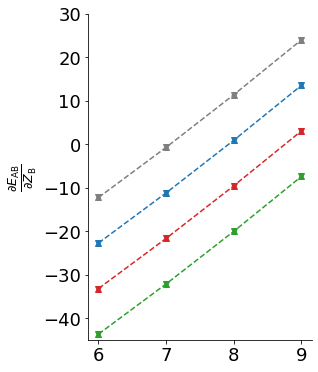

In [49]:
r = 2
row = r
df_deri = dict()
for k in deri_dict[r].keys():
    df_deri[k] = deri_dict[r][k][1]
df_deri = pd.DataFrame(df_deri).T

plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [4,6]
fig, ax = plt.subplots(1,1)


if row == 2:
    #Z = [5,6,7,8,9]
    Z = [6,7,8,9]
    color = dict(zip([5,6,7,8,9], ['#db9c9cff','#7f7f7fff', '#1f77b4ff', '#d62728ff', '#2ca02cff']))
elif row == 3:
    #Z = [13, 14, 15, 16, 17]
    Z = [14, 15, 16, 17]
    color = dict(zip([13, 14, 15, 16, 17], ['#bba2a2ff', '#ecbe90ff', '#df770eff', '#d5d528ff', '#1ca01cff']))
elif row == 4:
    #Z = [31, 32, 33, 34, 35]
    Z = [32, 33, 34, 35]
    color = dict(zip([31, 32, 33, 34, 35], ['#cc9797ff', '#567676ff', '#a977c8ff', '#f4a51dff', '#942a2aff']))

for i in df_deri.index:
    plt.plot(list(df_deri.index), df_deri.T[i], '--v', color = color[i])
    plt.plot(list(df_deri.index), hammett_prediction(df_deri, param_dict[r]).T[i], '^', color = color[i])
        


if r == 3 or r == 4:
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    pass
else:
    #ax.set_xlabel(r'$Z_{\rm{B}}$')
    ax.set_ylabel(r'$\frac{\partial E_{\rm{AB}}}{\partial Z_{\rm{B}}}$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim([-45, 30])
#ax.set_xlim([min(Z)-0.5, max(Z)+0.5])
#ax.legend()
plt.savefig(f'/home/sahre/work/bonding_trends/figures/results/hammett_pred_row{r}.svg', bbox_inches = 'tight')

In [10]:
color

{13: '#bba2a2ff',
 14: '#ecbe90ff',
 15: '#df770eff',
 16: '#d5d528ff',
 17: '#1ca01cff'}

In [48]:
sigmas = np.array([ param_dict[r].dicsigmas[_] for _ in df_deri.index ])

x0 = np.array([ param_dict[r].dicx0[_] for _ in df_deri.columns ]) 

rhos = np.array([ param_dict[r].dicrho[_] for _ in df_deri.columns ])

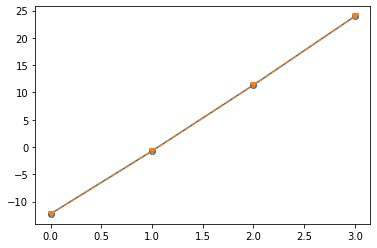

### $\sigma$ and $x_0$

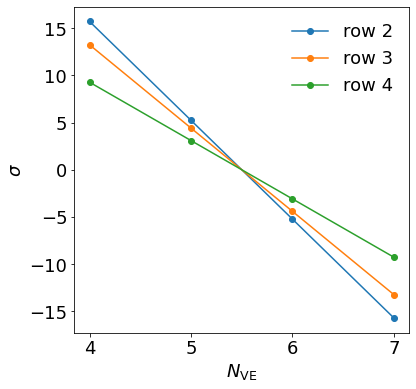

In [67]:
plt.rcParams['figure.figsize'] = [6,6]
plt.rcParams['font.size'] = 18
for r in [2,3,4]:
    #plt.plot(param_dict[r].dicsigmas.keys(), param_dict[r].dicsigmas.values(), '-o')
    plt.plot([4,5,6,7], param_dict[r].dicsigmas.values(), '-o', label = f'row {r}')
plt.xlabel(r'$N_{\rm{VE}}$')
plt.ylabel(r'$\sigma$')
plt.legend(frameon= False)

# plt.savefig('/home/sahre/work/bonding_trends/figures/results/hammett_sigma.svg', bbox_inches = 'tight')

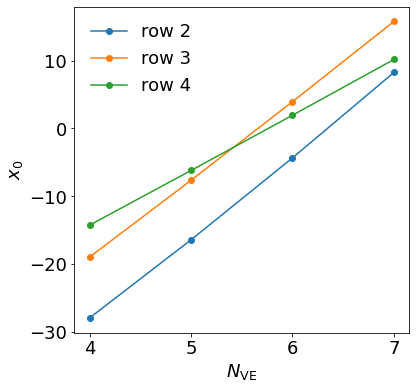

In [68]:
plt.rcParams['figure.figsize'] = [6,6]
plt.rcParams['font.size'] = 18
for r in [2,3,4]:
    plt.plot([4,5,6,7], param_dict[r].dicx0.values(), '-o', label = f'row {r}')
    
plt.xlabel(r'$N_{\rm{VE}}$')
plt.ylabel(r'$x_0$')
plt.legend(frameon = False)

# plt.savefig('/home/sahre/work/bonding_trends/figures/results/hammett_x0.svg', bbox_inches = 'tight')

In [ ]:
param_dict[2].dicsigmas - param_dict[2].x0[6]

In [ ]:
hammett_prediction(df_deri, params)

In [ ]:
row = 4
uqm.load_obj(f'/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/derivatives/deri_row{row}')


In [ ]:
# multiple predictions

In [ ]:
for i in range(8, 12):#range(len(deri_group['IV'])):
    ref = []
    for k in deri_group.keys():
        ref.append(deri_group[k][i])
    plt.plot(ref)
    plt.plot(df_deri_pred.loc[df_deri_pred.index == i].T, '--')

In [ ]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [16,4]
fig, ax = plt.subplots(1,4)
pos_E = 0
pos_dE = 1
pos_sig = 2
pos_x0 = 3
for ZA, c in zip(Z, color):
    # plot of binding energy
    ax[pos_E].plot(Z_dict_ref[ZA][0], Z_dict_ref[ZA][1], '-o', label = f'ZA = {ZA}', color = color[ZA])
    ax[pos_E].plot(Z_dict_nonlinear[ZA][0], Z_dict_nonlinear[ZA][1], '-.^', color = color[ZA])
    
    # plot of derivative
    ax[pos_dE].plot([min(Z)-0.5, max(Z)+0.5], [0,0], '--', color = 'tab:gray')
    ax[pos_dE].plot(Z_dict_deri_nl[ZA][0], Z_dict_deri_nl[ZA][1], '--v', color = color[ZA], label = f'ZA = {ZA}')

ax[pos_E].set_xlabel(r'$Z_{\rm{B}}$')
ax[pos_E].set_ylabel(r'$ E_{\rm{AB}}$ (kcal/mol)')
    
ax[pos_dE].set_xlabel(r'$Z_{\rm{B}}$')
ax[pos_dE].set_ylabel(r'$\frac{\partial E_{\rm{AB}}}{\partial Z_{\rm{B}}}$')
ax[pos_dE].spines['right'].set_visible(False)
ax[pos_dE].spines['top'].set_visible(False)
ax[pos_dE].set_xlim([min(Z)-0.5, max(Z)+0.5])
#ax[0].legend()

ax[pos_sig].plot(Z, params.sigmas, '-o')
ax[pos_sig].set_xlabel(r'$Z_{\rm{B}}$')
ax[pos_sig].set_ylabel(r'$\sigma$')

ax[pos_x0].plot(Z, params.x0, '-o')
ax[pos_x0].set_xlabel(r'$Z_{\rm{A}}$')
ax[pos_x0].set_ylabel(r'$x_0$')

for i in range(4):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

fig.tight_layout()
#plt.savefig(f'/home/sahre/work/bonding_trends/figures/results/hammett_row{row}', bbox_inches = 'tight')

In [ ]:
hammett_params_dict[row] = {'sigma':params.sigmas, 'x0':params.x0}

In [ ]:
hammett_params_dict

In [ ]:
plt.rcParams['figure.figsize'] = [8,4]
gig, ax = plt.subplots(1,2)
main_group = [4,5,6,7]
for k in hammett_params_dict.keys():
    ax[0].plot(main_group, hammett_params_dict[k]['sigma'], '-o', label = f'row = {k}')
    ax[1].plot(main_group, hammett_params_dict[k]['x0'], '-o')
    
ax[0].set_xlabel(r'main group')
ax[0].set_ylabel(r'$\sigma$')
ax[0].legend(frameon = False)
ax[1].set_xlabel(r'main group')
ax[1].set_ylabel(r'$x_0$')

for i in range(2):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
plt.savefig(f'/home/sahre/work/bonding_trends/figures/results/hammett_sigma_x0', bbox_inches = 'tight')

In [ ]:
main_group = [4,5,6,7]
for k in hammett_params_dict.keys():
    plt.plot(main_group, hammett_params_dict[k]['x0'], '-o')

In [ ]:
import pandas as pd
data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies_homolytic.csv')
data_2 = data.loc[(data['Z1'] <= 9) & (data['Z2'] <= 9)].to_dict('list')


In [ ]:
-630*np.array(data_2['bfe'])

In [ ]:
# row 2
Z1 = [5, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 8, 8, 9]
Z2 = [5, 6, 7 ,8 , 9, 6, 7, 8, 9, 7, 8, 9, 8, 9, 9]
xdata = np.array([Z1, Z2]).T
bde = 0.24*np.array([431.6, 426.8, 583.3, 626, 705.4, 359.2, 337.7, 370.2, 452, 259.6, 253.5, 283.6, 195.2, 194.9, 151.7])

#bde = np.array([110.49385254, 110.93407811, 149.27676277, 157.11721558, 171.95861673,  98.49528829,  93.20659964,  98.91705917, 115.21436085, 75.66071618,  67.20964411,  75.14743054,  54.47427191,51.72306432,  38.13809699])

bde_homo = bde[[0, 5, 9, 12, 14]]#np.array([103.584, 86.208,  62.304, 46.848, 36.408])

elements = ['B', 'C', 'N', 'O', 'F']
bde_homo = dict(zip(elements, bde_homo))

In [ ]:
# row 3
Z1 = [13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 16, 16, 17]
Z2 = [13, 14, 15, 16, 17, 14, 15, 16, 17, 15, 16, 17, 16, 17, 17]
xdata = np.array([Z1, Z2]).T
#bde = 0.24*np.array([257.9, 289.4, 294.5, 402.5, 502.5, 313.2, 287.3, 357.4, 448.4, 225.8, 263.7, 315.1, 252, 258.3, 234.6])

bde_pbe = np.array([ 59.79920224,  69.86379766,  73.47519514,  98.90234845,
       121.12181215, 77.25620984,  74.02914862,  90.49612881, 110.73043846,
        62.75882065,  71.1649616 ,  82.8305566 ,  70.27237772,
        69.51302798,  62.47957441])

bde_homo = bde[[0, 5, 9, 12, 14]]
elements = ['Al', 'Si', 'P', 'S', 'Cl']

bde_homo = dict(zip(elements, bde_homo))

In [ ]:
# row 4
Z1 = [31.0, 31.0, 31.0, 31.0, 31.0, 32, 32, 32, 32, 33, 33, 33, 34, 34, 35]
Z2 = [31.0, 32.0, 33.0, 34.0, 35.0, 32, 33, 34, 35, 33, 34, 35, 34, 35, 35]
xdata = np.array([Z1, Z2]).T

bde = np.array([65.14864892, 69.02427881, 66.26409022, 85.56362194, 99.50397576,72.21042554, 64.45730305, 74.92547657, 88.99081342, 53.84647516,
       59.52618602, 68.87128326, 59.71296505, 59.3387519 , 54.46767659])

bde_homo = bde[[0, 5, 9, 12, 14]]
elements = ['Ga', 'Ge', 'As', 'Se', 'Br']

bde_homo = dict(zip(elements, bde_homo))

In [ ]:
plt.plot(bde)

In [ ]:
a = np.sqrt(215)
b = -np.sqrt(10)
c = np.sqrt(2)

af, bf, cf = curve_fit(non_linear_model_bde, xdata, ydata=bde, p0=[a,b,c])[0]

In [ ]:
mae = np.abs(bde-non_linear_model_bde(xdata, af, bf, cf)).mean()

In [ ]:
np.abs(bde[5:]-non_linear_model_bde(xdata, af, bf, cf)[5:]).mean()

In [ ]:
# Pauling
chi = {'H':2.1, 'Li':1.0, 'B':2,'C':2.5, 'N':3.0, 'O':3.5, 'F':4.0, 
       'Al':1.5, 'Si':1.8, 'P':2.1, 'S':2.5, 'Cl':3.0,
       'Ga':1.6, 'Ge':1.8, 'As':2.0, 'Se':2.4, 'Br':2.8}

bde_pauling = []
for i in range(5):
    for j in range(i, 5):
        el_A = elements[i]
        el_B = elements[j]
        
        chi_A = chi[el_A]
        chi_B = chi[el_B]
        E_AA = bde_homo[el_A]
        E_BB = bde_homo[el_B]
        
        E_AB = (E_AA + E_BB)/2 + 23*(chi_A - chi_B)**2
        bde_pauling.append(E_AB)
        
bde_pauling = np.array(bde_pauling)
mae_pauling = np.abs(bde_pauling-bde).mean()

In [ ]:
el_dict = {5:'B', 6:'C', 7:'N', 8:'O', 9:'F', 
           13:'Al', 14:'Si', 15:'P', 16:'S', 17:'Cl',
           31:'Ga', 32:'Ge', 33:'As', 34:'Se', 35:'Br'}

In [ ]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['font.size'] = 14

xlabels = []
for el1, el2 in xdata:
    xlabels.append(el_dict[el1] + el_dict[el2])

plt.plot(xlabels, bde, '-o', label = 'ref')
plt.plot(non_linear_model_bde(xdata, af, bf, cf), '-o', label = f'fit, MAE = {np.round(mae, 1)} kcal/mol')
plt.plot(bde_pauling, '-v', label = f'Pauling, MAE = {np.round(mae_pauling, 1)}')

plt.ylabel('BDE (kcal/mol)')
plt.legend()

In [ ]:
plt.rcParams['figure.figsize'] = [4,4]
plt.rcParams['font.size'] = 18

plt.plot([np.amin(bde), np.amax(bde)], [np.amin(bde), np.amax(bde)], '--', color = 'tab:gray')
plt.plot(bde, non_linear_model_bde(xdata, af, bf, cf), 'o')

plt.xlabel('BDE ref (kcal/mol)')
plt.ylabel('BDE model (kcal/mol)')